In [52]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from geopandas import GeoDataFrame, read_file,GeoSeries
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx

## read data

In [53]:
df = pd.read_feather('data/2021-10_odt.feather')

In [54]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['duration(mins)'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

df['day_of_week'] = df['start_time'].dt.day_name()
# delete duration = 0
df = df[df['duration(mins)'] > 0]

In [55]:
df

,index,oaid_origin,oaid_des,start_time,end_time,duration(mins),day_of_week
0,0,E00000021,E00000007,2021-10-13 11:43:00,2021-10-13 12:07:00,24.0,Wednesday
1,0,E00174772,E00000007,2021-10-17 13:20:00,2021-10-17 13:39:00,19.0,Sunday
2,0,E00000024,E00000007,2021-10-14 08:04:00,2021-10-14 08:05:00,1.0,Thursday
3,0,E00000024,E00000007,2021-10-19 08:32:00,2021-10-19 08:48:00,16.0,Tuesday
4,0,E00017723,E00000007,2021-10-19 06:59:00,2021-10-19 07:53:00,54.0,Tuesday
...,...,...,...,...,...,...,...
3138526,4834,E00176525,E00008169,2021-10-20 07:33:00,2021-10-20 07:40:00,7.0,Wednesday
3138527,4834,E00008167,E00008169,2021-10-13 08:58:00,2021-10-13 08:59:00,1.0,Wednesday
3138528,4834,E00008167,E00008169,2021-10-22 21:04:00,2021-10-22 21:05:00,1.0,Friday
3138529,4834,E00008149,E00008169,2021-10-24 16:42:00,2021-10-24 17:46:00,64.0,Sunday


In [56]:
df.to_feather('data/2021-10_odt_new.feather')

## 

C:\Users\dune\AppData\Local\Temp\ipykernel_4976\2758470719.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)


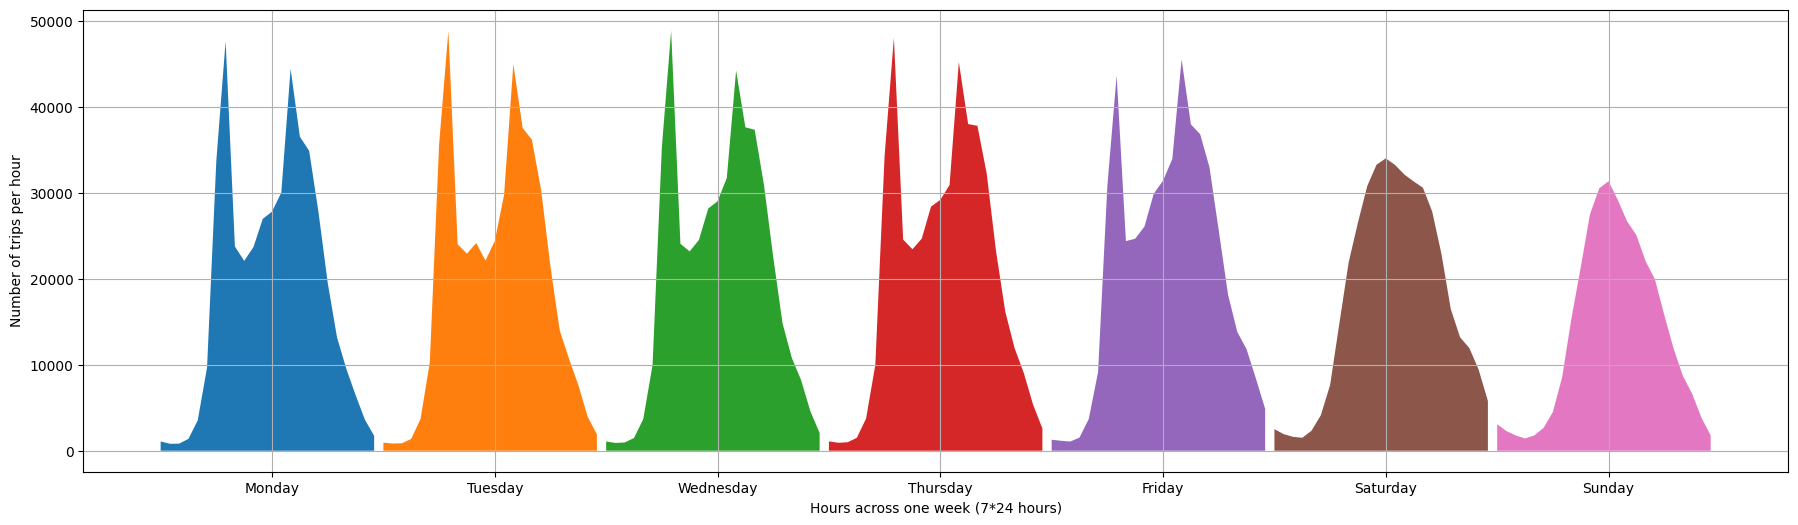

In [57]:
df['hour'] = df['start_time'].dt.hour
# Reorder the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

# Group by day of the week and hour, then count the number of trips
grouped = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(22, 6))
# Loop over each day to plot on the correct x-axis range
for i, day in enumerate(days_order):
    plt.fill_between(range(i*24, (i+1)*24), grouped.loc[day], label=day)

# plt.title('Number of Trips per Hour Across the Week')
plt.xlabel('Hours across one week (7*24 hours)')
plt.ylabel('Number of trips per hour')
plt.xticks(ticks=[i*24 + 12 for i in range(7)], labels=days_order)  # X-axis ticks for each day at mid-day
plt.grid(True)
plt.savefig('output/number_of_trips_per_hour_across_the_week.jpg', dpi=600)
plt.show()


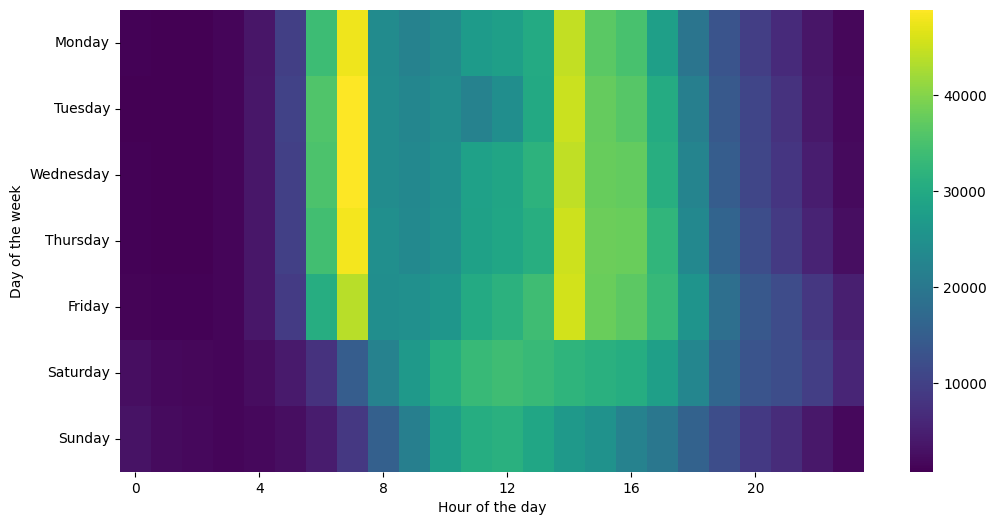

In [58]:
# plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(grouped, cmap='viridis', xticklabels=4)
# plt.title('Number of Trips per Hour Across the Week')
plt.xlabel('Hour of the day')
plt.ylabel('Day of the week')
plt.savefig('output/number_of_trips_per_hour_across_the_week_heatmap.jpg', dpi=600)
plt.show()

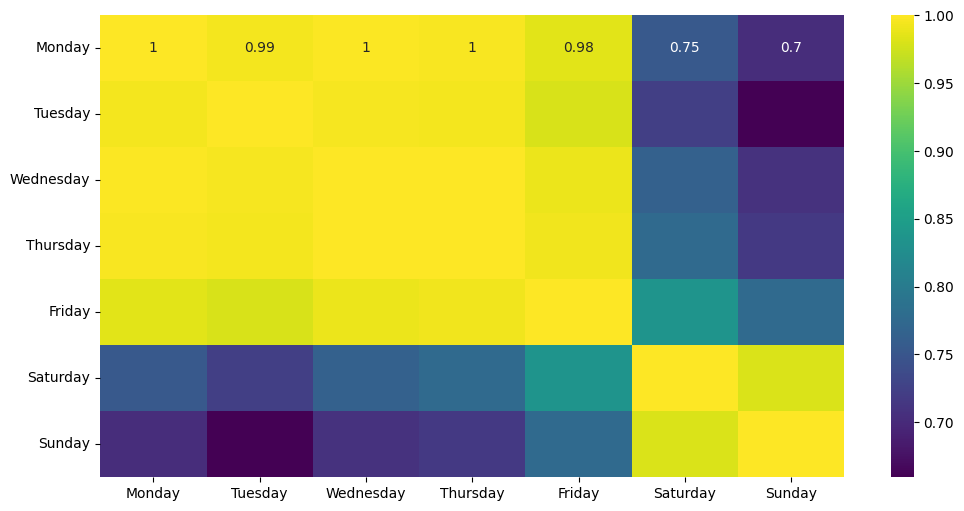

In [59]:
# plot correlation matrix temporal pattern by days of the week not by hours
plt.figure(figsize=(12, 6))
sns.heatmap(grouped.T.corr(), cmap='viridis', annot=True)
# plt.title('Correlation Matrix of Temporal Patterns by Days of the Week')
plt.xlabel('')
plt.ylabel('')
plt.savefig('output/correlation_matrix_of_temporal_patterns_by_days_of_the_week.png')
plt.show()

administritive boundary data 

In [60]:
oa_london = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
oa_london = oa_london.to_crs(epsg=27700)

ward_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
ward_shp = ward_shp.to_crs(epsg=27700)

borough_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
borough_shp = borough_shp.to_crs(epsg=27700)

msoa_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
msoa_shp = msoa_shp.to_crs(epsg=27700)


In [61]:
oa_london_df = pd.DataFrame(oa_london)

# merge the oa_london_df with the df, use oaid_origin in df and OA11CD in oa_london_df
df_merge = pd.merge(df, oa_london_df, left_on='oaid_origin', right_on='OA11CD', how='left')
df_merge = df_merge[['index', 'oaid_origin', 'oaid_des', 'LSOA11CD','MSOA11CD','geometry','start_time', 'end_time', 'duration(mins)','day_of_week']]
df_merge.rename(columns={'LSOA11CD':'LSOA11CD_origin', 'MSOA11CD':'MSOA11CD_origin','geometry':'geometry_origin'}, inplace=True)

df_merge_od = pd.merge(df_merge, oa_london_df, left_on='oaid_des', right_on='OA11CD', how='left')
df_merge_od = df_merge_od[['index', 'oaid_origin', 'oaid_des', 'LSOA11CD_origin','MSOA11CD_origin','geometry_origin','start_time', 'end_time', 'duration(mins)', 'LSOA11CD','MSOA11CD','geometry','day_of_week']]
df_merge_od.rename(columns={'LSOA11CD':'LSOA11CD_des', 'MSOA11CD':'MSOA11CD_des','geometry':'geometry_des'}, inplace=True)


In [62]:
df_origin = df_merge_od.drop(columns=['geometry_des'])
df_des = df_merge_od.drop(columns=['geometry_origin'])

In [63]:
df_origin

,index,oaid_origin,oaid_des,LSOA11CD_origin,MSOA11CD_origin,geometry_origin,start_time,end_time,duration(mins),LSOA11CD_des,MSOA11CD_des,day_of_week
0,0,E00000021,E00000007,E01000002,E02000001,"POLYGON ((532603.000 181795.000, 532619.141 18...",2021-10-13 11:43:00,2021-10-13 12:07:00,24.0,E01000001,E02000001,Wednesday
1,0,E00174772,E00000007,E01002704,E02000576,"POLYGON ((532759.871 182369.050, 532768.000 18...",2021-10-17 13:20:00,2021-10-17 13:39:00,19.0,E01000001,E02000001,Sunday
2,0,E00000024,E00000007,E01032739,E02000001,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2021-10-14 08:04:00,2021-10-14 08:05:00,1.0,E01000001,E02000001,Thursday
3,0,E00000024,E00000007,E01032739,E02000001,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2021-10-19 08:32:00,2021-10-19 08:48:00,16.0,E01000001,E02000001,Tuesday
4,0,E00017723,E00000007,E01003508,E02000744,"POLYGON ((540060.314 181589.011, 540150.000 18...",2021-10-19 06:59:00,2021-10-19 07:53:00,54.0,E01000001,E02000001,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
3109381,4834,E00176525,E00008169,E01001644,E02006931,"POLYGON ((537477.591 176995.094, 537514.035 17...",2021-10-20 07:33:00,2021-10-20 07:40:00,7.0,E01033746,E02006931,Wednesday
3109382,4834,E00008167,E00008169,E01001641,E02006931,"POLYGON ((538265.000 177330.999, 538316.000 17...",2021-10-13 08:58:00,2021-10-13 08:59:00,1.0,E01033746,E02006931,Wednesday
3109383,4834,E00008167,E00008169,E01001641,E02006931,"POLYGON ((538265.000 177330.999, 538316.000 17...",2021-10-22 21:04:00,2021-10-22 21:05:00,1.0,E01033746,E02006931,Friday
3109384,4834,E00008149,E00008169,E01001641,E02006931,"POLYGON ((538643.171 178080.498, 538663.086 17...",2021-10-24 16:42:00,2021-10-24 17:46:00,64.0,E01033746,E02006931,Sunday


In [65]:
# Convert 'geometry_origin' column to a compatible data type
df_origin['geometry_origin'] = df_origin['geometry_origin'].apply(lambda x: x.wkt if x else None)

# Save the data to feather file
df_origin.to_feather('data/od_origin.feather')


In [67]:
df_des['geometry_des'] = df_des['geometry_des'].apply(lambda x: x.wkt if x else None)
df_des.to_feather('data/od_des.feather')

In [ ]:
df_merge_od['oaid_origin'].nunique()

25038

In [ ]:
df_merge_od['LSOA11CD_origin'].nunique()

4835

In [ ]:
df_merge_od['MSOA11CD_origin'].nunique()

983

 plot the number of od pairs

In [42]:
od_count = df_merge_od.groupby(['MSOA11CD_origin', 'MSOA11CD_des']).size().reset_index(name='count')
od_count = od_count[od_count['count'] > 0]
# od_count = od_count.sort_values(by='count', ascending=False)
od_count

,MSOA11CD_origin,MSOA11CD_des,count
0,E02000001,E02000001,10306
1,E02000001,E02000002,4
2,E02000001,E02000003,48
3,E02000001,E02000004,8
4,E02000001,E02000005,2
...,...,...,...
185019,E02006931,E02006927,54
185020,E02006931,E02006928,432
185021,E02006931,E02006929,132
185022,E02006931,E02006930,183


In [43]:
# save od_count
od_count.to_feather('data/od_count.feather')

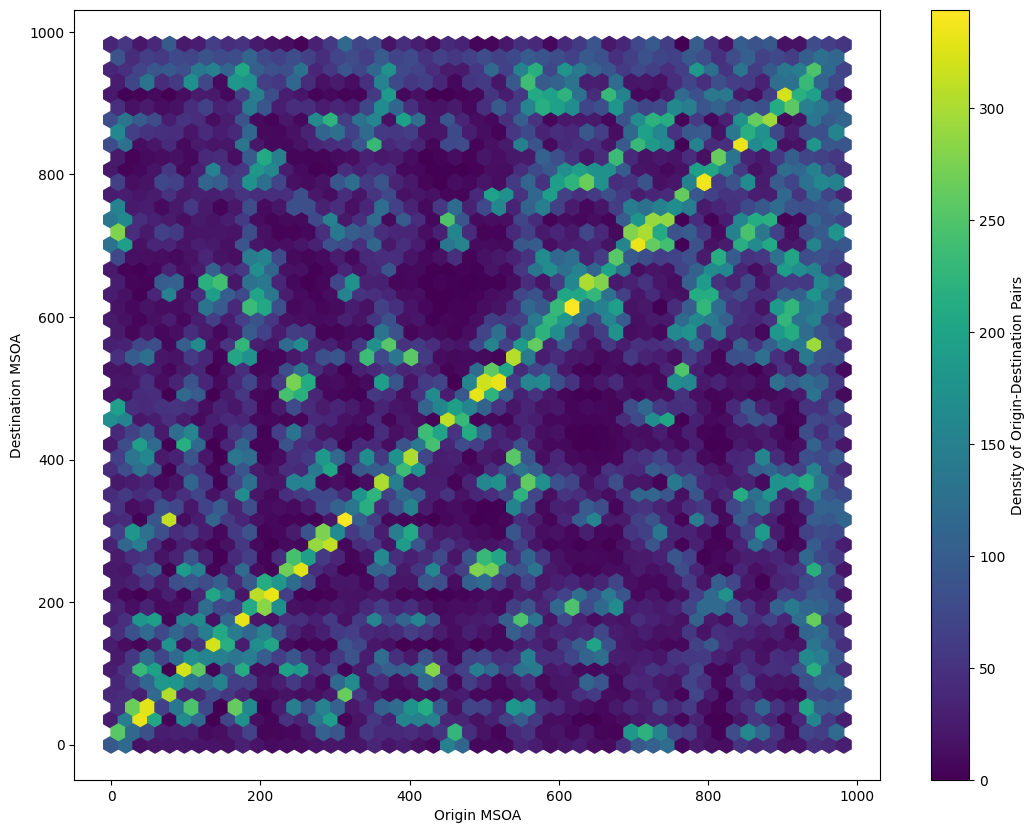

In [44]:
# Create a mapping dictionary to convert MSOA codes to float values
msoa_mapping = {code: i for i, code in enumerate(od_count['MSOA11CD_origin'].unique())}

# Apply the mapping to the 'MSOA11CD_origin' and 'MSOA11CD_des' columns
od_count['MSOA11CD_origin'] = od_count['MSOA11CD_origin'].map(msoa_mapping)
od_count['MSOA11CD_des'] = od_count['MSOA11CD_des'].map(msoa_mapping)

# Plot the density of the origin-destination pairs
plt.figure(figsize=(13, 10))
plt.hexbin(od_count['MSOA11CD_origin'], od_count['MSOA11CD_des'], gridsize=50, cmap='viridis')
# add colorbar
plt.colorbar(label='Density of Origin-Destination Pairs')
plt.xlabel('Origin MSOA')
plt.ylabel('Destination MSOA')
#plt.title('Density of Origin-Destination Pairs')
plt.savefig('output/density_of_origin_destination_pairs.jpg', dpi=600)


weekend and weekday

In [47]:
od_count_weekday = df_merge_od[df_merge_od['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
od_count_weekend = df_merge_od[df_merge_od['day_of_week'].isin(['Saturday', 'Sunday'])]
od_count_weekday = od_count_weekday.groupby(['MSOA11CD_origin', 'MSOA11CD_des']).size().reset_index(name='count')
od_count_weekend = od_count_weekend.groupby(['MSOA11CD_origin', 'MSOA11CD_des']).size().reset_index(name='count')
od_count_weekday = od_count_weekday[od_count_weekday['count']>0]
od_count_weekend = od_count_weekend[od_count_weekend['count']>0]
od_count_weekday.to_feather('data/od_count_weekday.feather')
od_count_weekend.to_feather('data/od_count_weekend.feather')

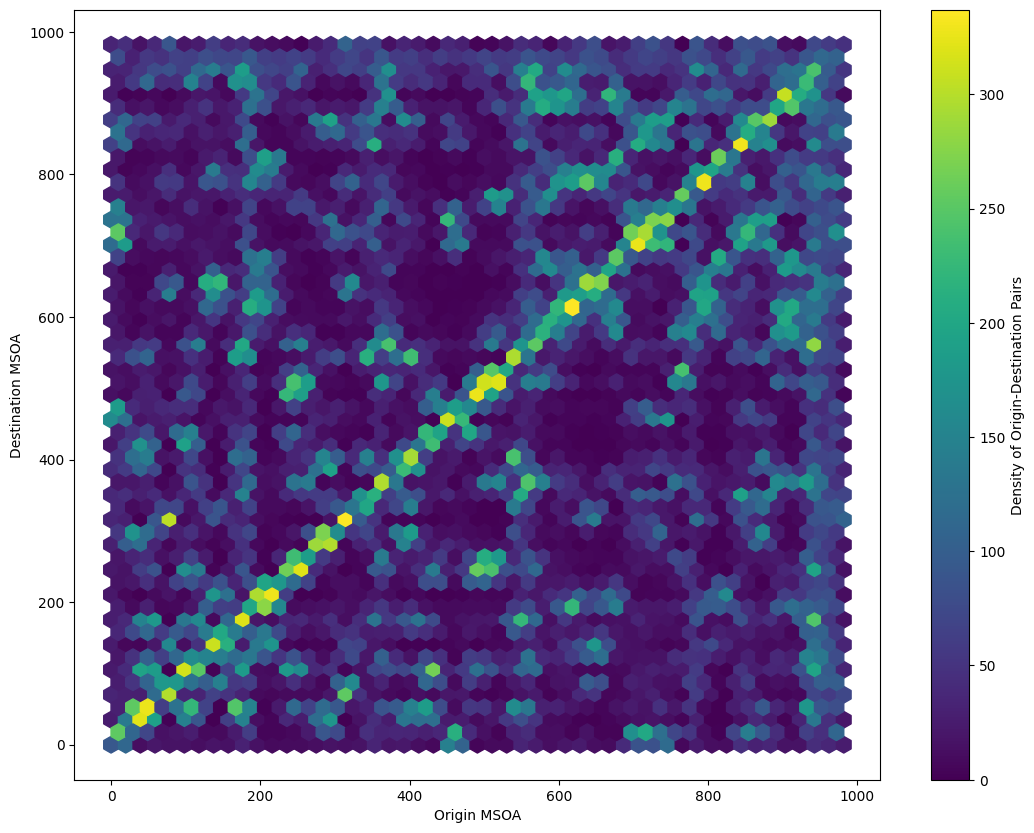

In [48]:
msoa_mapping_weekday = {code: i for i, code in enumerate(od_count_weekday['MSOA11CD_origin'].unique())}
msoa_mapping_weekend = {code: i for i, code in enumerate(od_count_weekend['MSOA11CD_origin'].unique())}

od_count_weekday['MSOA11CD_origin'] = od_count_weekday['MSOA11CD_origin'].map(msoa_mapping_weekday)
od_count_weekday['MSOA11CD_des'] = od_count_weekday['MSOA11CD_des'].map(msoa_mapping_weekday)
od_count_weekend['MSOA11CD_origin'] = od_count_weekend['MSOA11CD_origin'].map(msoa_mapping_weekend)
od_count_weekend['MSOA11CD_des'] = od_count_weekend['MSOA11CD_des'].map(msoa_mapping_weekend)

plt.figure(figsize=(13, 10))
plt.hexbin(od_count_weekday['MSOA11CD_origin'], od_count_weekday['MSOA11CD_des'], gridsize=50, cmap='viridis')
plt.colorbar(label='Density of Origin-Destination Pairs')
plt.xlabel('Origin MSOA')
plt.ylabel('Destination MSOA')
#plt.title('Density of Origin-Destination Pairs (Weekdays)')
plt.savefig('output/density_of_origin_destination_pairs_weekdays.jpg', dpi=600)

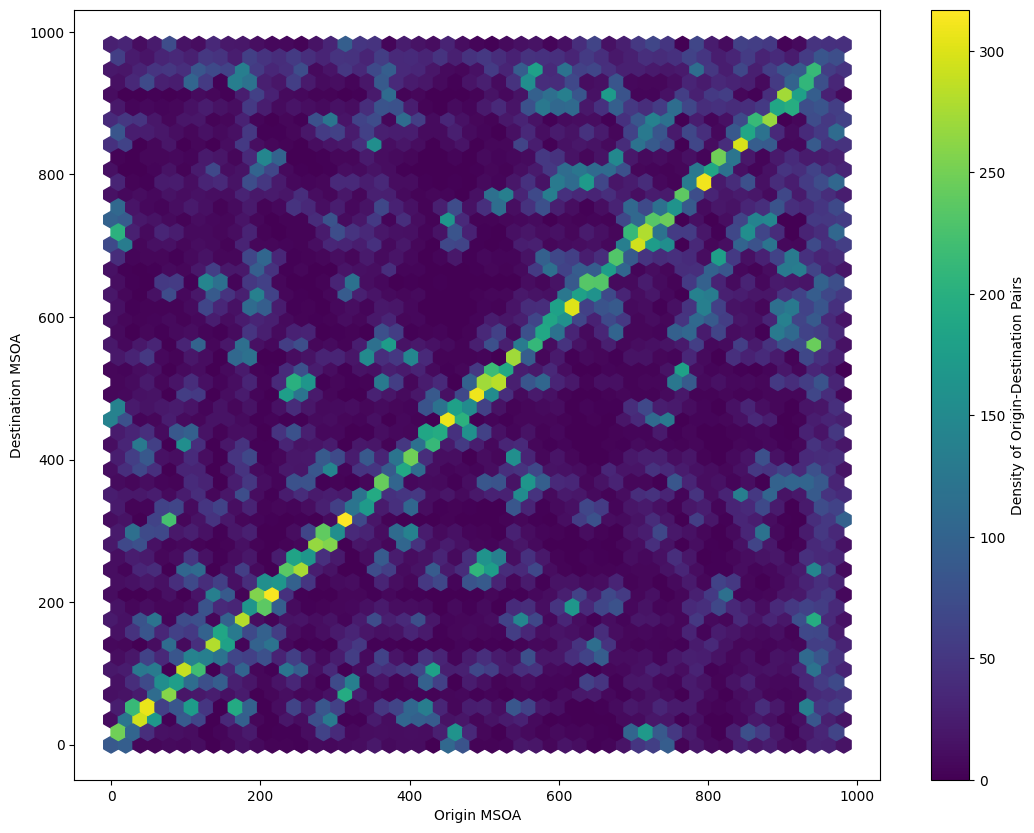

In [49]:
plt.figure(figsize=(13, 10))
plt.hexbin(od_count_weekend['MSOA11CD_origin'], od_count_weekend['MSOA11CD_des'], gridsize=50, cmap='viridis')
plt.colorbar(label='Density of Origin-Destination Pairs')
plt.xlabel('Origin MSOA')
plt.ylabel('Destination MSOA')
#plt.title('Density of Origin-Destination Pairs (Weekends)')
plt.savefig('output/density_of_origin_destination_pairs_weekends.jpg', dpi=600)
